In [1]:
# this notebook depends on "TempestExtremes" package which can be installed with
# conda install -c conda-forge tempest-extremes

In [76]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS, WANDB_PROJECT
from utils import wandb_to_beaker_result, beaker_to_xarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from io import StringIO
import pandas as pd
plt.rcParams['figure.dpi'] = 200
from typing import Sequence

In [130]:
def load_tracks(filename) -> Sequence[pd.DataFrame]:
    columns = ['lon_index', 'lat_index', 'lon', 'lat', 'slp', 'wind', 'zs', 'year', 'month', 'day', 'hour']
    with open(filename) as f:
        tracks = []
        current_track = None
        for line in f:
            if line.startswith('start'):
                if current_track is not None:
                    data = StringIO('\n'.join(current_track))
                    df = pd.read_csv(data, sep='\t', header=None, names=columns)
                    tracks.append(df)
                current_track = []
            else:
                current_track.append(line)
    return tracks

def plot_six(ds):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    ds.PRESsfc.plot(ax=axes[0])
    ds.TMP2m.plot(ax=axes[2])
    ds.sea_level_pressure.plot(ax=axes[1], vmax=104000)
    ds.air_temperature_3.plot(ax=axes[3])
    ds.UGRD10m.plot(ax=axes[4])
    ds.VGRD10m.plot(ax=axes[5])
    fig.tight_layout()
    for ax in axes:
        ax.coastlines(linewidth=0.5, color='grey')
        ax.set_title(ds.time.values)

In [3]:
URL_ERA5 = 'gs://vcm-ml-intermediate/2024-06-20-era5-1deg-8layer-1940-2022.zarr'
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS['100day']
beaker_dataset_id = wandb_to_beaker_result(WANDB_PROJECT, wandb_id)
beaker_dataset_id

/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/util.py:25: RuntimeWarning: Found unknown field 'node_has_gpus: True' for data model 'Job'. This may be a newly added field that hasn't been defined in beaker-py yet. Please submit an issue report about this here:
https://github.com/allenai/beaker-py/issues/new?assignees=&labels=bug&template=bug_report.yml
  warnings.warn(


'01J687SMXCCKZ02GNDRF7PRFFG'

In [115]:

ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = ds_pred.isel(sample=0)
ds_pred['time'] = ds_pred.valid_time

ds_target = beaker_to_xarray(beaker_dataset_id, "autoregressive_target.nc")
ds_target = ds_target.isel(sample=0)
ds_target['time'] = ds_target.valid_time

Output()

Output()

In [116]:
surface_height = xr.open_zarr(URL_ERA5)['HGTsfc'].load()
ds_pred = xr.merge(
    [ds_pred, surface_height.rename(latitude='lat', longitude='lon')],
    compat='override',
    join='override',
).assign_coords(source='ACE2-ERA5')

ds_target = xr.merge(
    [ds_target, surface_height.rename(latitude='lat', longitude='lon')],
    compat='override',
    join='override',
).assign_coords(source='ERA5')

ds = xr.concat([ds_pred, ds_target], dim='source')

In [117]:
# Constants
R = 287.05  # specific gas constant for dry air in J/(kg*K)
g = 9.8065  # acceleration due to gravity in m/s^2
TREF = 273.0 # reference temperature in K

# Compute SLP from surface pressure
ds['sea_level_pressure'] = ds['PRESsfc'] * np.exp((g * ds['HGTsfc']) / (R * ds['TMP2m']))
ds.sea_level_pressure.attrs = {'units': 'Pa', 'long_name': 'Sea level pressure'}
#ds['sea_level_pressure'] = ds['PRESsfc'] * np.exp((g * ds['HGTsfc']) / (R * TREF))

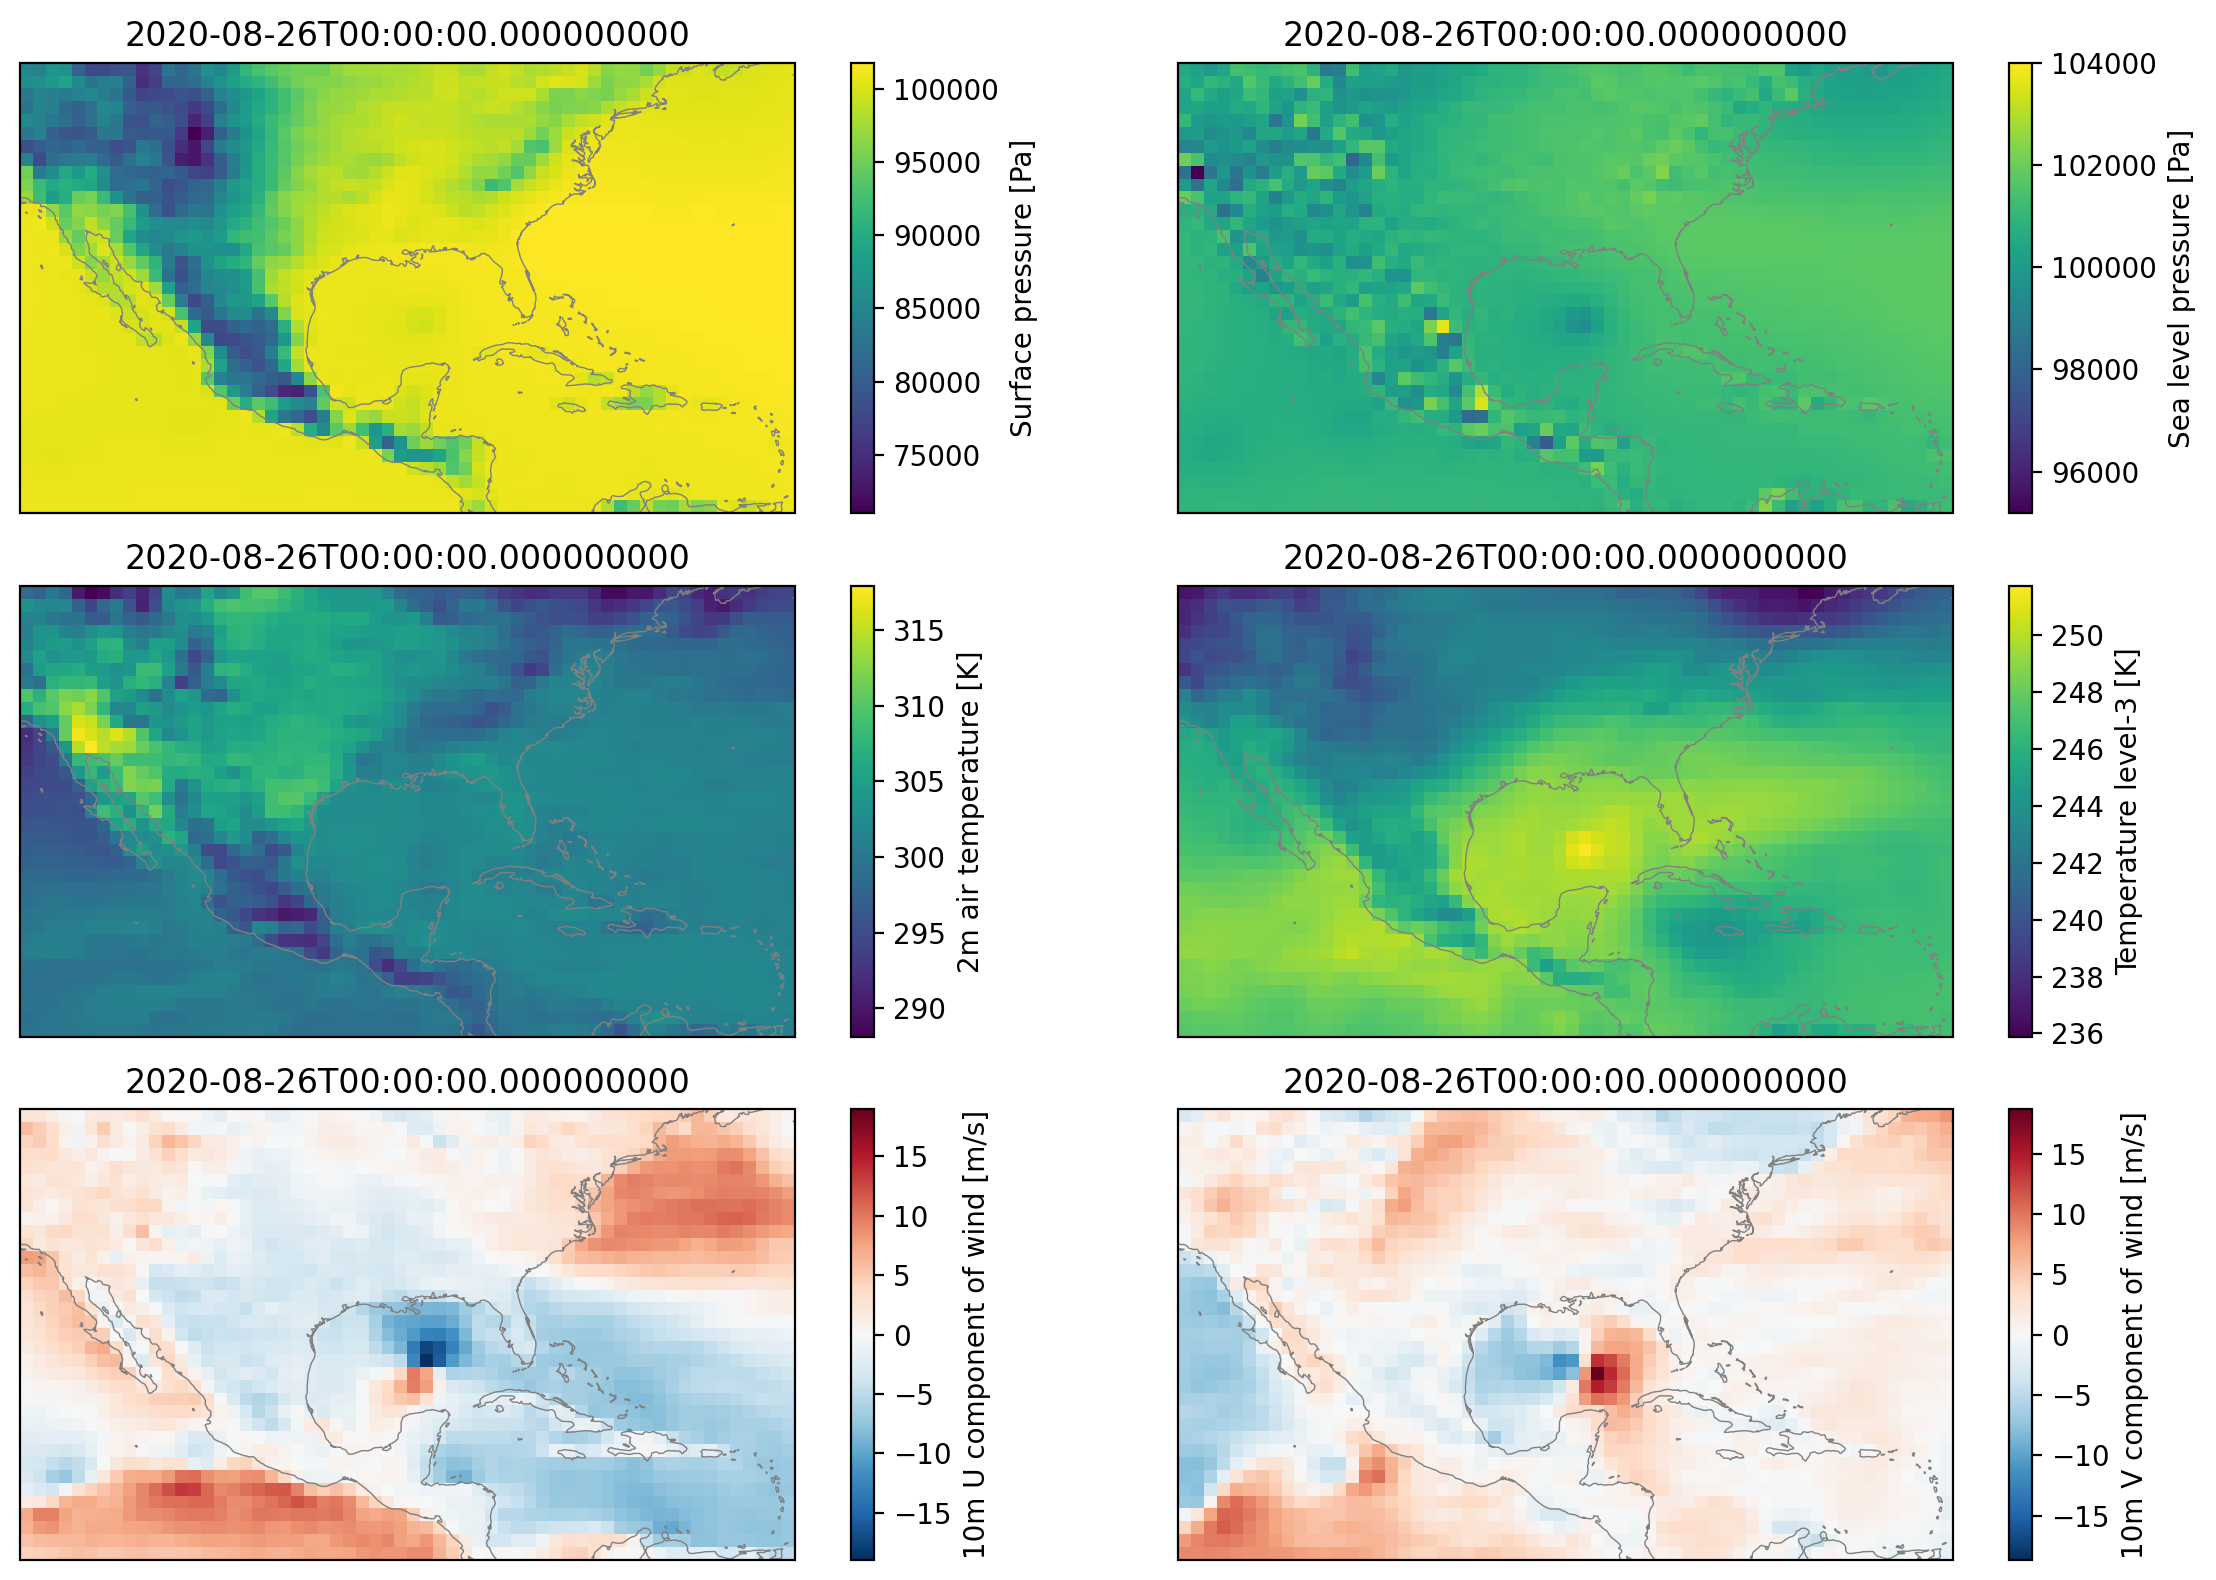

In [119]:
TIME = '2020-08-26T00:00:00'
plot_six(ds.sel(source='ERA5', time=TIME, lat=slice(10, 45), lon=slice(240, 300)))

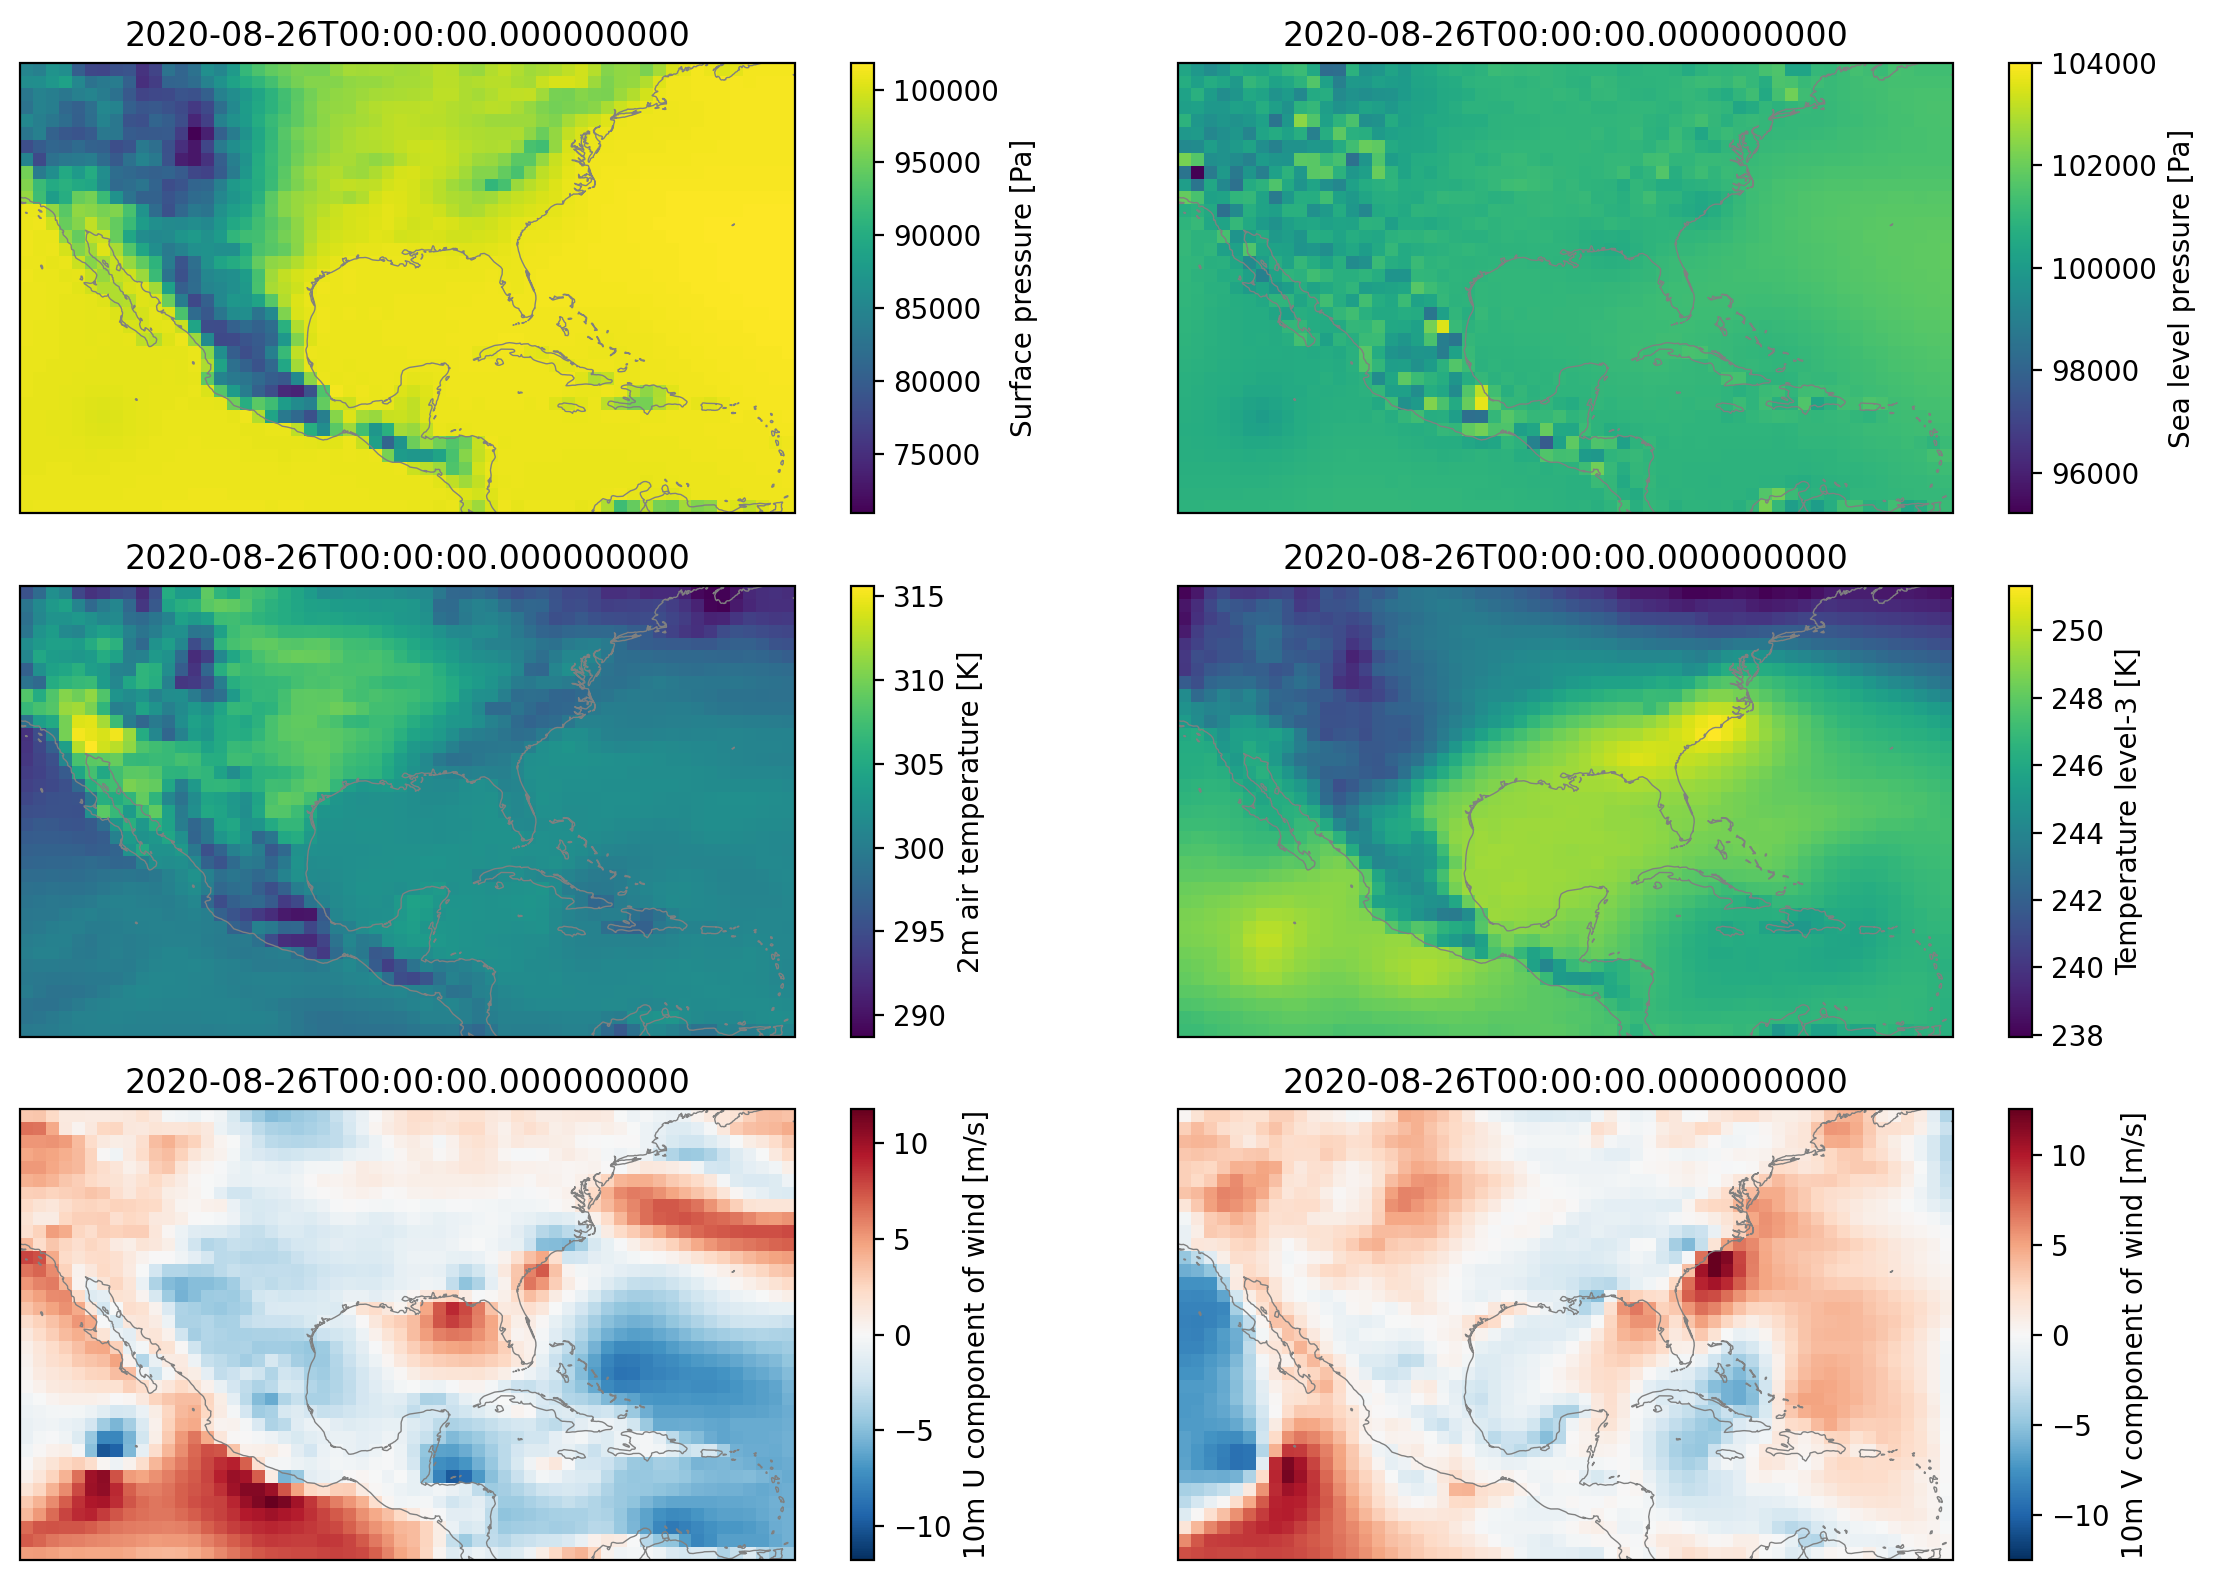

In [120]:
TIME = '2020-08-26T00:00:00'
plot_six(ds.sel(source='ACE2-ERA5', time=TIME, lat=slice(10, 45), lon=slice(240, 300)))

### Save data to disk and run TC detection

In [127]:
ds.sel(source='ERA5').convert_calendar('gregorian').transpose('time', 'lat', 'lon').to_netcdf('ERA5_tc_raw_data.nc')
ds.sel(source='ACE2-ERA5').convert_calendar('gregorian').transpose('time', 'lat', 'lon').to_netcdf('ACE2-ERA5_tc_raw_data.nc')

In [128]:
%%bash

# first do it for actual ERA5 data
DetectNodes \
    --in_data ERA5_tc_raw_data.nc \
    --out ERA5_candidate_points.txt \
    --searchbymin sea_level_pressure \
    --closedcontourcmd "sea_level_pressure,200.0,5.5,0;air_temperature_3,-1,6.5,1.0" \
    --mergedist 6.0 \
    --outputcmd "sea_level_pressure,min,0;_VECMAG(UGRD10m,VGRD10m),max,2;HGTsfc,min,0"

StitchNodes \
    --in ERA5_candidate_points.txt \
    --out ERA5_TC_tracks.txt \
    --in_fmt "lon,lat,slp,wind,zs" \
    --range 8.0 \
    --mintime "54h" \
    --maxgap "24h" \
    --threshold "wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10;zs,<=,150.0,10"

# now do it for the ACE2-ERA5 simulation
DetectNodes \
    --in_data ACE2-ERA5_tc_raw_data.nc \
    --out ACE2-ERA5_candidate_points.txt \
    --searchbymin sea_level_pressure \
    --closedcontourcmd "sea_level_pressure,200.0,5.5,0;air_temperature_3,-1,6.5,1.0" \
    --mergedist 6.0 \
    --outputcmd "sea_level_pressure,min,0;_VECMAG(UGRD10m,VGRD10m),max,2;HGTsfc,min,0"

StitchNodes \
    --in ACE2-ERA5_candidate_points.txt \
    --out ACE2-ERA5_TC_tracks.txt \
    --in_fmt "lon,lat,slp,wind,zs" \
    --range 8.0 \
    --mintime "54h" \
    --maxgap "24h" \
    --threshold "wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10;zs,<=,150.0,10"

Arguments:
  --in_data <string> ["ERA5_tc_raw_data.nc"] 
  --in_data_list <string> [""] 
  --in_connect <string> [""] 
  --diag_connect <bool> [false] 
  --out <string> ["ERA5_candidate_points.txt"] 
  --out_file_list <string> [""] 
  --searchbymin <string> ["sea_level_pressure"] (default PSL)
  --searchbymax <string> [""] 
  --searchbythreshold <string> [""] 
  --minlon <double> [0.000000] (degrees)
  --maxlon <double> [0.000000] (degrees)
  --minlat <double> [0.000000] (degrees)
  --maxlat <double> [0.000000] (degrees)
  --minabslat <double> [0.000000] (degrees)
  --mergedist <double> [6.000000] (degrees)
  --closedcontourcmd <string> ["sea_level_pressure,200.0,5.5,0;air_temperature_3,-1,6.5,1.0"] [var,delta,dist,minmaxdist;...]
  --noclosedcontourcmd <string> [""] [var,delta,dist,minmaxdist;...]
  --thresholdcmd <string> [""] [var,op,value,dist;...]
  --outputcmd <string> ["sea_level_pressure,min,0;_VECMAG(UGRD10m,VGRD10m),max,2;HGTsfc,min,0"] [var,op,dist;...]
  --timestride <integ

..Time 2020-08-20 18:00:00
....Total candidates: 7
....Rejected (  location): 0
....Rejected (    merged): 2987
....Rejected ( threshold): 0
....Rejected (contour sea_level_pressure): 58
....Rejected (contour air_temperature_3): 131
....Done
..Time 2020-08-21 00:00:00
....Total candidates: 4
....Rejected (  location): 0
....Rejected (    merged): 2979
....Rejected ( threshold): 0
....Rejected (contour sea_level_pressure): 58
....Rejected (contour air_temperature_3): 123
....Done
..Time 2020-08-21 06:00:00
....Total candidates: 3
....Rejected (  location): 0
....Rejected (    merged): 3054
....Rejected ( threshold): 0
....Rejected (contour sea_level_pressure): 58
....Rejected (contour air_temperature_3): 125
....Done
..Time 2020-08-21 12:00:00
....Total candidates: 2
....Rejected (  location): 0
....Rejected (    merged): 3001
....Rejected ( threshold): 0
....Rejected (contour sea_level_pressure): 57
....Rejected (contour air_temperature_3): 129
....Done
..Time 2020-08-21 18:00:00
....T

In [131]:
tracks_era5 = load_tracks('ERA5_TC_tracks.txt')
tracks_ace2_era5 = load_tracks('ACE2-ERA5_TC_tracks.txt')

In [135]:
def plot_tracks(ax, tracks, title):
    for track in tracks:
        ax.plot(track.lon, track.lat, marker='o', linestyle='-', transform=ccrs.PlateCarree(), markersize=1)
    ax.coastlines()
    ax.set_title(f"{len(tracks)} tracks. {title}")

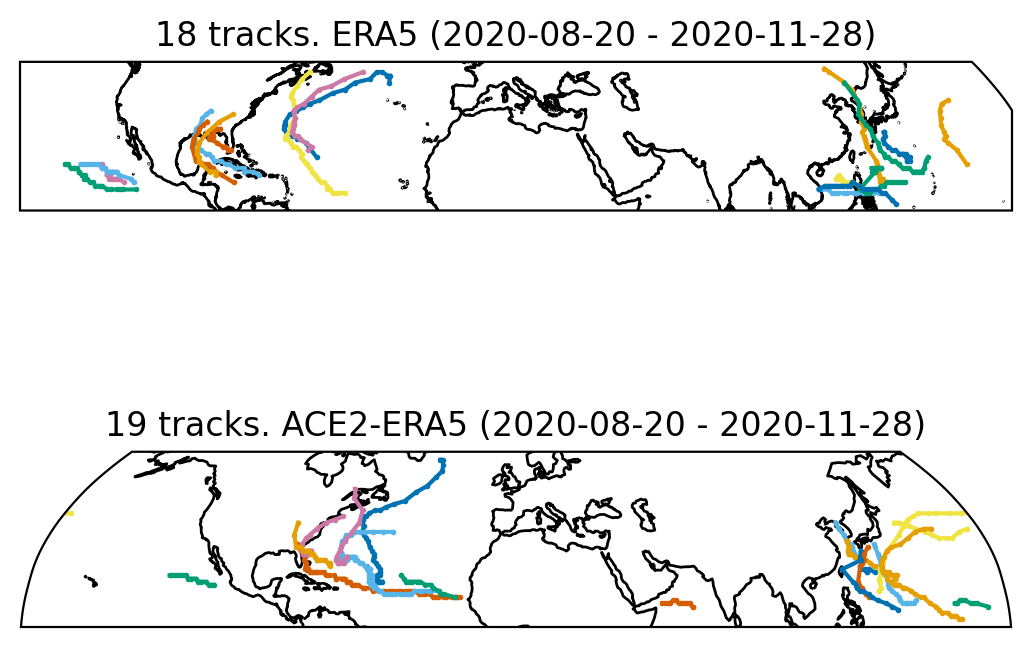

In [136]:
start_time = ds.time.values[0].astype('datetime64[D]')
end_time = ds.time.values[-1].astype('datetime64[D]')

fig, axes = plt.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()})
plot_tracks(axes[0], tracks_era5, f"ERA5 ({start_time} - {end_time})")
plot_tracks(axes[1], tracks_ace2_era5, f"ACE2-ERA5 ({start_time} - {end_time})")

In [137]:
def plot_track_variables(tracks):
    fig, axes = plt.subplots(2, 1)
    for i, track in enumerate(tracks):
        track['time'] = pd.to_datetime(track[['year', 'month', 'day', 'hour']])
        track = track.set_index('time')
        track = track.sort_index()
        track['wind'].plot(ax=axes[0])
        track['slp'].plot(ax=axes[1])
    axes[0].set_ylabel('Wind speed [m/s]')
    axes[0].set_title('Maximum 10m wind speed with 2° of candidate point')
    axes[0].set_xlabel('')
    axes[1].set_ylabel('Sea level pressure [Pa]')
    axes[1].set_title('Sea level pressure at candidate point')
    axes[1].set_xlabel('')
    fig.tight_layout()

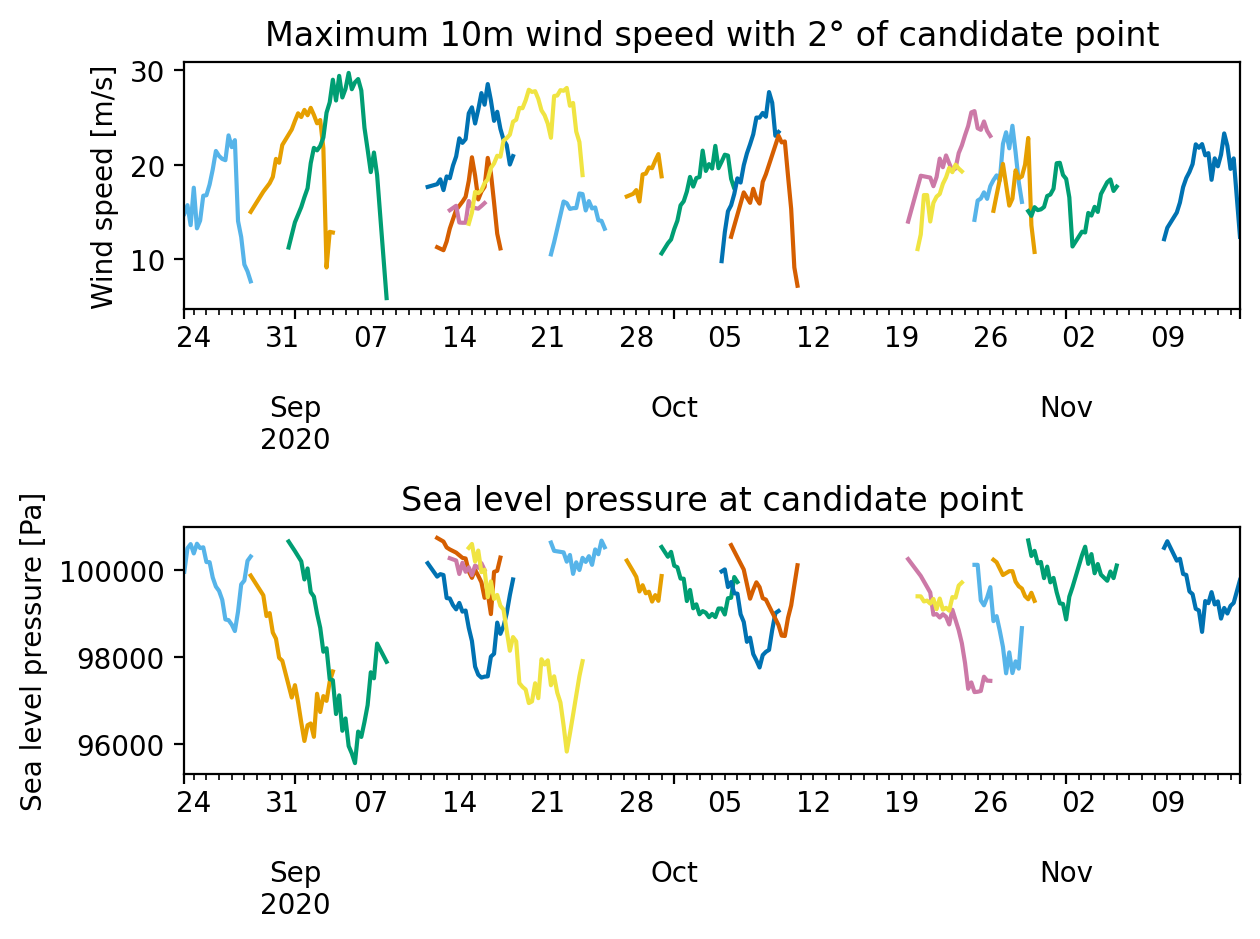

In [138]:
plot_track_variables(tracks_era5)

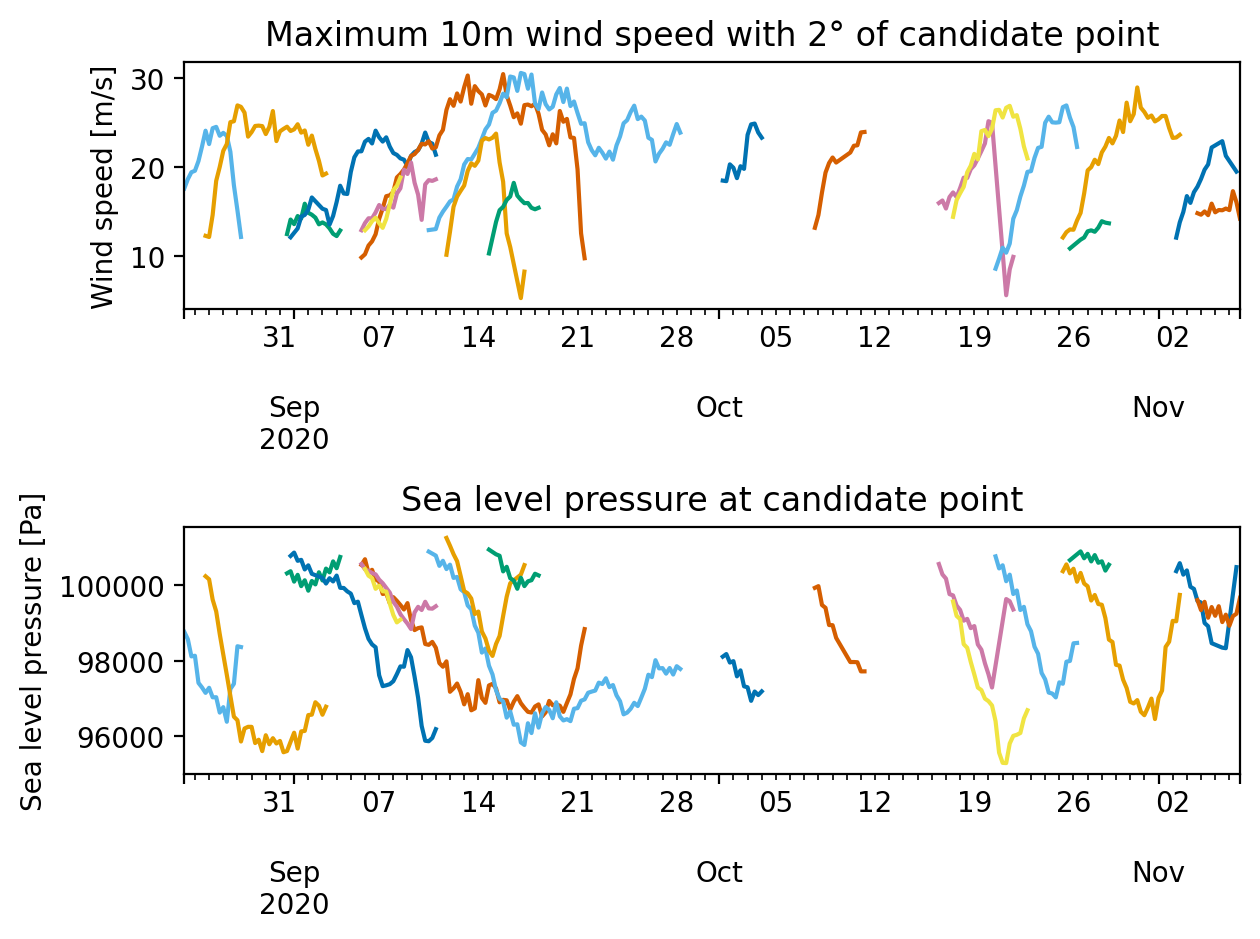

In [139]:
plot_track_variables(tracks_ace2_era5)